<a href="https://colab.research.google.com/github/hyunjaec/MScA_Deep_Learning_Project/blob/main/zoning_satellite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from scipy import ndimage, signal as sg
from skimage import data, filters, io, color
from sklearn.model_selection import train_test_split
from PIL import Image
import glob
import cv2
from google.colab.patches import cv2_imshow
import keras
from keras.datasets import mnist
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten,BatchNormalization, Input, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import applications
from skimage.filters.rank import median, mean

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
!pwd

/content


In [ ]:
#connect colab with google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#label csv
austin_df = pd.read_csv("/content/drive/My Drive/Data/data/austin.csv")
austin_df = austin_df.drop('Unnamed: 0', axis = 1)
austin_df.head()

,image_name,zoning_id,zoning_zty
0,data/austin_0.jpg,229791,PUD
1,data/austin_1.jpg,229791,PUD
2,data/austin_2.jpg,400523442,I-RR
3,data/austin_3.jpg,229791,PUD
4,data/austin_4.jpg,229791,PUD


In [ ]:
residential = ['LA',
            'RR',
            'SF-1',
            'SF-2',
            'SF-3',
            'SF-4A',
            'SF-4-A,'
            'SF-4B',
            'SF-5',
            'SF-6',
            'MF-1',
            'MF-2',
            'MF-3',
            'MF-4',
            'MF-5',
            'MF-6',
            'MF-CO',
            'MH']

commercial = ['NO',
            'LO',
            'GO',
            'CR',
            'LR',
            'GR',
            'L',
            'CBD',
            'DMU',
            'W/LO',
            'CS',
            'CS-1',
            'CH']

industrial = ['IP', 'LI', 'MI', 'R&D']

special = ['DR', 'AV', 'AG', 'P', 'PUD', 'TN', 'ERC', 'UNZ']

In [ ]:
#loop through list of zone codes, map specific zone codes to R, C, I, or S
austin_df.loc[:, 'zone'] = np.nan

for i in residential:
    austin_df.loc[:, 'zone'] = np.where(austin_df.loc[:, 'zoning_zty'].str.contains(i) == True, 
                                     'R', austin_df.loc[:,'zone'])
for i in industrial:
    austin_df.loc[:, 'zone'] = np.where(((austin_df.loc[:, 'zoning_zty'].str.contains(i) == True) & (austin_df.loc[:, 'zone'] != 'R')), 
                                     'I', austin_df.loc[:,'zone'])
for i in commercial:
    austin_df.loc[:, 'zone'] = np.where((austin_df.loc[:, 'zoning_zty'].str.contains(i) == True) & \
                                     (austin_df.loc[:, 'zone'] != 'R') & (austin_df.loc[:, 'zone'] != 'I'), 
                                     'C', austin_df.loc[:,'zone'])
for i in special:
    austin_df.loc[:, 'zone'] = np.where((austin_df.loc[:, 'zoning_zty'].str.contains(i) == True) & \
                                     (austin_df.loc[:, 'zone'] != 'I') & (austin_df.loc[:, 'zone'] != 'R') &\
                                     (austin_df.loc[:, 'zone'] != 'C'), 
                                     'S', austin_df.loc[:,'zone'])

In [ ]:
#manually set this one
austin_df.loc[303, 'zone'] = 'R'

In [ ]:
austin_df.head()

,image_name,zoning_id,zoning_zty,zone
0,data/austin_0.jpg,229791,PUD,S
1,data/austin_1.jpg,229791,PUD,S
2,data/austin_2.jpg,400523442,I-RR,R
3,data/austin_3.jpg,229791,PUD,S
4,data/austin_4.jpg,229791,PUD,S


(array([1235.,    0.,    0., 1747.,    0.,    0.,  446.,    0.,    0.,
         239.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

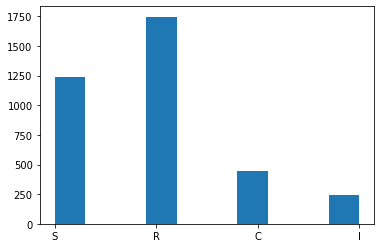

In [ ]:
plt.hist(austin_df['zone'])

In [ ]:
img_names = austin_df['image_name']

In [ ]:
dim = (200, 200)

In [ ]:
# img_df = []
# # for i in img_names:
# #     img_df.append(cv2.imread(('../'+ str(i))))
# for i, img in enumerate(img_names):
#     visual_img = image.load_img(('/content/drive/My Drive/Data/'+img), target_size=dim)  
#     img_array = image.img_to_array(visual_img)
#     img_array = median(img_array, 1.0/9.0 * np.ones((3, 3)))
#     img_df.append(img_array)

In [ ]:
dim = (200, 200)
img_df = []
for i in img_names:
  visual_img = cv2.imread("/content/drive/My Drive/Data/" + str(i[:-4])+".jpg")
  visual_img = cv2.resize(visual_img, dim, interpolation = cv2.INTER_AREA)
  visual_img = cv2.fastNlMeansDenoisingColored(visual_img,None,10,10,7,15)
  img_df.append(visual_img)

In [ ]:
img_array = np.array(img_df) 
img_array.shape

(3667, 200, 200, 3)

In [ ]:
#make images equal pixel by 500, 500 
# for i, img in enumerate(img_df):
#   img_df[i] = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

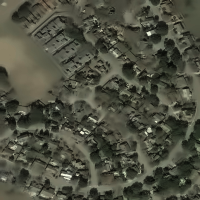

In [ ]:
cv2_imshow(img_array[53])

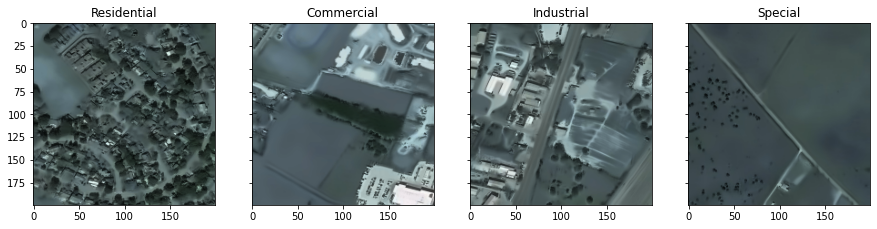

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15, 15), sharex=True, sharey=True)
ax1, ax2, ax3, ax4 = ax.ravel()

ax1.imshow(np.array(img_array[53],np.int32))
ax1.set_title('Residential')

ax2.imshow(np.array(img_array[138],np.int32))
ax2.set_title('Commercial')

ax3.imshow(np.array(img_array[397],np.int32))
ax3.set_title('Industrial')

ax4.imshow(np.array(img_array[72],np.int32))
ax4.set_title('Special')


plt.show()

In [ ]:
img_df2 = np.array(img_df) 
zone_class = np.array(austin_df['zone']) 
zone_class = pd.get_dummies(zone_class)
#split labels and images for train&test
X_train, X_test, y_train, y_test = train_test_split(img_df2, zone_class, test_size=.3)
input_shape = (200, 200, 3)

In [ ]:
datagen = ImageDataGenerator(
#     rotation_range=30,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     validation_split=0.2
    rescale=1.0/255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
    )

datagen.fit(X_train)

In [ ]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(7, 7),
                 activation='relu', 
                 input_shape=input_shape))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 194, 194, 64)      9472      
                                                                 
 conv2d_19 (Conv2D)          (None, 190, 190, 64)      102464    
                                                                 
 batch_normalization_12 (Bat  (None, 190, 190, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 95, 95, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 93, 93, 32)        18464     
                                                                 
 batch_normalization_13 (Bat  (None, 93, 93, 32)      

In [ ]:
model = applications.efficientnet_v2.EfficientNetV2L(weights = "imagenet", include_top=False, input_shape = (200, 200, 3))

473186304/473176280 [==============================] - 3s 0us/step


In [1]:
#model.summary()

In [ ]:
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(4, activation="softmax")(x)

# creating the final model 
model_final = Model(model.input, predictions)

In [2]:
#model_final.summary()

In [ ]:
model.compile(optimizer= tf.optimizers.SGD(learning_rate=0.001, momentum=0.9), loss="mean_squared_error", metrics=["accuracy"])

In [ ]:
batch_size = 20
epochs = 50

In [ ]:
y_test.shape

(1101, 4)

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size, subset='training'), 
                    validation_data=datagen.flow(X_train, y_train, batch_size=int(batch_size/4), subset='validation'),
                    epochs=epochs)

Epoch 1/50
103/103 [==============================] - 21s 199ms/step - loss: 0.1982 - accuracy: 0.5129 - val_loss: 0.2537 - val_accuracy: 0.2183
Epoch 2/50
103/103 [==============================] - 20s 194ms/step - loss: 0.1858 - accuracy: 0.5558 - val_loss: 0.2144 - val_accuracy: 0.3899
Epoch 3/50
103/103 [==============================] - 21s 202ms/step - loss: 0.1790 - accuracy: 0.5509 - val_loss: 0.2062 - val_accuracy: 0.3899
Epoch 4/50
103/103 [==============================] - 20s 192ms/step - loss: 0.1692 - accuracy: 0.5548 - val_loss: 0.2263 - val_accuracy: 0.3528
Epoch 5/50
103/103 [==============================] - 20s 194ms/step - loss: 0.1610 - accuracy: 0.5679 - val_loss: 0.1877 - val_accuracy: 0.4542
Epoch 6/50
103/103 [==============================] - 20s 194ms/step - loss: 0.1458 - accuracy: 0.5860 - val_loss: 0.1503 - val_accuracy: 0.5809
Epoch 7/50
103/103 [==============================] - 20s 193ms/step - loss: 0.1400 - accuracy: 0.5977 - val_loss: 0.1562 - val_ac

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score)

Test loss: [0.24038206040859222, 0.5004541277885437]


Text(0.5, 1.0, 'Loss Curves')

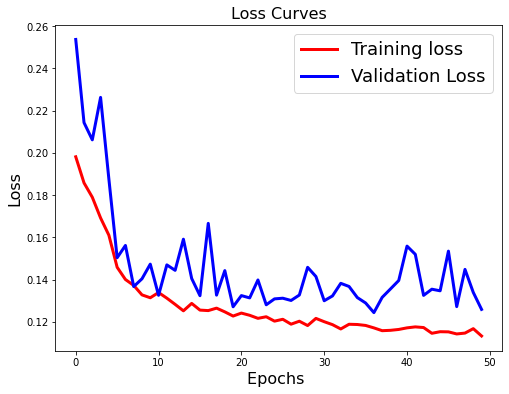

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

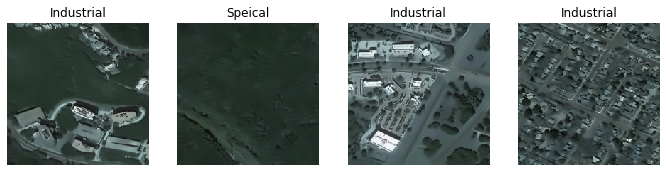

In [ ]:
class_names = ['Residnetial', 'Commercial', 'Industrial','Speical']
images_and_labels = list(zip(X_test, y_test))
plt.figure(figsize=(30,30))
for index, (image, label) in enumerate(images_and_labels):
    plt.subplot(4, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    index = np.where(label == 1)
    imagedata = image[np.newaxis, :, :]
    pred = model.predict(imagedata)
    pred= pred[0].argmax(axis=0)
    plt.title(class_names[pred])
plt.show()